<a href="https://colab.research.google.com/github/nedokormysh/GB_App_Statistics_Med/blob/lesson_6_regression/GB_app_statistics_med_hw_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Урок 6.
Регрессионные модели

# Условие
На прошлых занятиях вы иногда формировали гипотезы, в которых ЗП была бинарной, а НП — непрерывной. Теперь вы можете проверить их корректно.

Попробуйте сгенерировать несколько выборок из имеющихся данных (вы уже знаете как), создать регрессионные модели по выбору и протестировать их предиктивную способность на сгенерированных данных. Не забывайте про оценку качества и доверительные интервалы.

In [1]:
packageVersion("rlang")
packageVersion("tidyverse")
packageVersion("dplyr")

[1] ‘1.1.3’

[1] ‘2.0.0’

[1] ‘1.1.4’

In [2]:
install.packages('skimr')
install.packages("boot")
install.packages("bootstrap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(tidyverse)
library(dplyr)
require(readxl)
library(httr)
library(skimr)
library("boot")
library("bootstrap")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: readxl



# Загрузка данных

In [4]:
hdl <- read_tsv('https://raw.githubusercontent.com/nedokormysh/GB_App_Statistics_Med/lesson_2_descriptive_statistics/high_density_lipids.tsv') |>
  select(-Name) |>
  mutate(Patient.number = as.factor(Patient.number),
         Vial.number = as.factor(Vial.number))

ldl <- read_tsv('https://raw.githubusercontent.com/nedokormysh/GB_App_Statistics_Med/lesson_2_descriptive_statistics/low_density_lipids.tsv') |>
  select(-Name) |>
  mutate(Patient.number = as.factor(Patient.number),
         Vial.number = as.factor(Vial.number))

# lipids <- full_join(hdl, ldl, by = c("Vial.number", "Patient.number"),
#  suffix = c('hdl', 'ldl'))

lipids <- merge(hdl, ldl, by = c("Vial.number", "Patient.number"),
                all = TRUE, suffix = c('_hdl', '_ldl'))

Rows: 27 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPHDL1, GPHDL2, GPHDL3, GPHDL4, GPHDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 29 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPLDL1, GPLDL2, GPLDL3, GPLDL4, GPLDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
url <- 'https://github.com/nedokormysh/GB_App_Statistics_Med/raw/lesson_2_descriptive_statistics/metadata.xlsx'

In [6]:
response <- GET(url, write_disk("metadata.xlsx", overwrite = TRUE))

In [9]:
meta <- read_xlsx('/content/metadata.xlsx', sheet = 1) |>
  rename_with(make.names)

descriptive <- read_xlsx('/content/metadata.xlsx', sheet = 2) |>
  rename('Variable' = '...1', 'Description' = '...2') |>
  drop_na()

descriptive <- descriptive %>%
  mutate(Variable = ifelse(row_number() == 10, "LVH", Variable))

for (col_name in colnames(meta)) {
  index <- match(col_name, descriptive$Variable)

  if (!is.na(index)) {
    attr(meta[[col_name]], 'label') <- descriptive$Description[index]
  }
}

# Выбираем столбцы с данными пациентов
patient_cols <- c('Vial.number',
                  'Patient.number',
                  'Name',
                  'Date',
                  'Age')

# Создаем таблицу с данными пациентов
patient_data <- meta[patient_cols]

# Создаем таблицу с клиническими данными
clinical_data <- meta |> select(-Name, -Age, -Date, -Sucrose)

# заменяем 3 точки на точку во всех названиях столбцов
colnames(clinical_data) <- sub("\\.+", ".", colnames(clinical_data))

colnames_factor = c('Vial.number', 'Patient.number', 'Group', 'Sm', 'Dm', 'HT',
                    'LVH', 'IHD', 'MI', 'Str', 'A_C', 'A_H', 'A_D', 'Plaque',
                    'Statins')

# преобразуем указанные столбцы в фактор
clinical_data[, colnames_factor] <- lapply(clinical_data[, colnames_factor], as.factor)

# Гипотезы

In [10]:
names(clinical_data)

[1] "Vial.number"      "Patient.number"   "Group"            "Plasma.volume"   
 [5] "Ht"               "Wt"               "BMI"              "Sys"             
 [9] "Dia"              "PR"               "Sm"               "Dm"              
[13] "HT"               "LVH"              "IHD"              "MI"              
[17] "Str"              "A_C"              "A_H"              "A_D"             
[21] "Choi.25"          "Tgi.26"           "HDLi.27"          "LDLi.28"         
[25] "Choi.29"          "Tgi.30"           "HDLi.31"          "LDLi.32"         
[29] "AI"               "r.lat.min"        "r.ant.min"        "r.pos.min"       
[33] "l.lat.min"        "l.ant.min"        "l.pos.min"        "r.lat.max"       
[37] "r.ant.max"        "r.pos.max"        "l.lat.max"        "l.ant.max"       
[41] "l.pos.max"        "carotid.IMT.mean" "Plaque"           "Statins"         
[45] "comorbidities"

## Гипотеза 1: простая логистическая регрессия

**Нулевая гипотеза (H0):**

Изменение независимой переменной (например, индекса массы тела) не влияет на вероятность зависимой переменной (например, наличия диабета, или Dm).

**Альтернативная гипотеза (H1):**

Изменение независимой переменной (например, индекса массы тела, или BMI) влияет на вероятность зависимой переменной (например, наличия диабета, или Dm).


In [11]:
# Выбираем зависимую и независимую гипотезы
dep_var <- "Dm"
indep_var <- "BMI"

In [13]:
check_normality <- function(indep_var, indep_var_name) {

  summary(indep_var)

  shapiro_test <- shapiro.test(indep_var)

  cat("Shapiro-Wilk test for normality:\n")
  print(shapiro_test)

  if (shapiro_test$p.value > 0.05) {
    cat("\nРаспределение переменной ", indep_var_name, " нормально.\n")
  } else {
    cat("\nРаспределение переменной ", indep_var_name, " ненормально.\n")
  }

  hist(indep_var, freq = FALSE, xlab = indep_var_name, main = "")
  lines(density(indep_var), col = "red", lwd = 2)

  qqnorm(indep_var, main = "QQ plot", xlab = "Theoretical quantiles", ylab = "Sample quantiles")
  qqline(indep_var, col = "red", lwd = 2)
}


Shapiro-Wilk test for normality:

	Shapiro-Wilk normality test

data:  indep_var
W = 0.93281, p-value = 0.02462


Распределение переменной  BMI  ненормально.


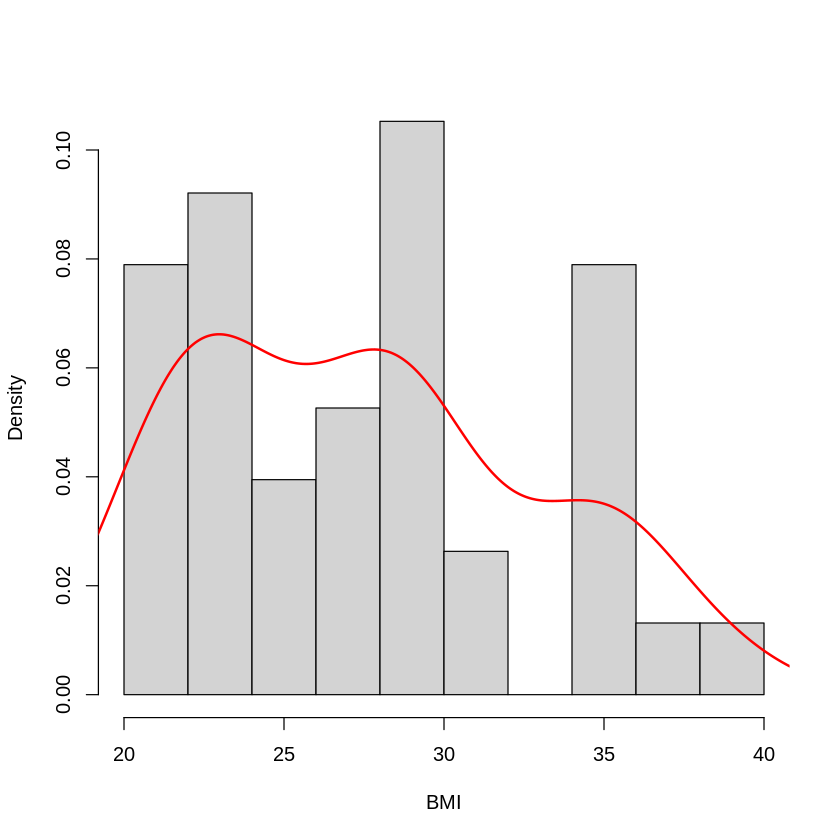

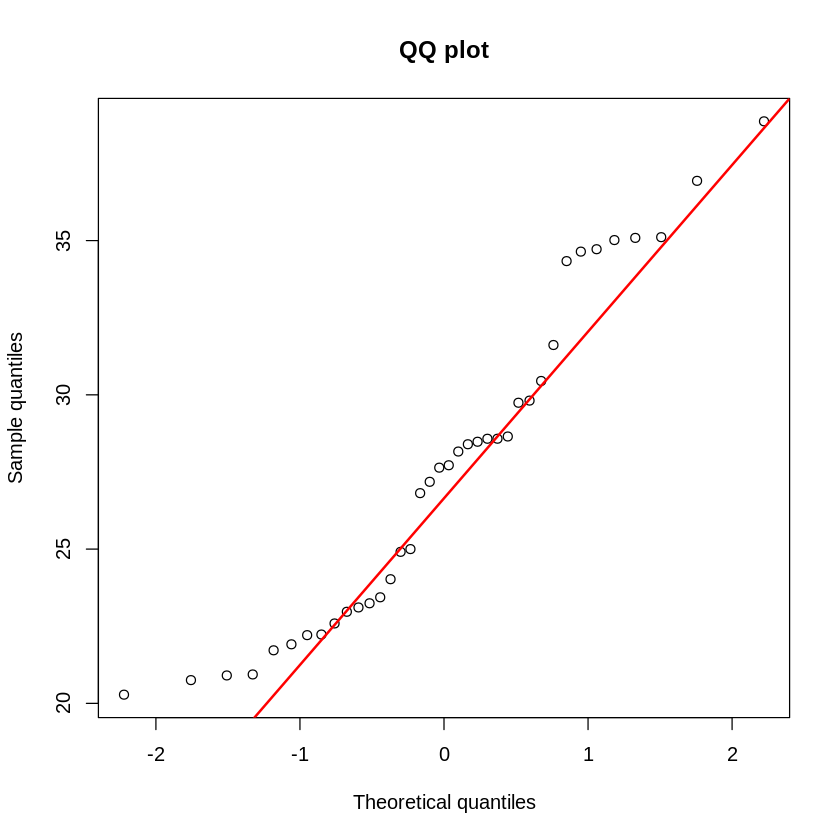

In [14]:
check_normality(clinical_data$BMI, 'BMI')

In [15]:
# Преобразуем в лог формат
log_BMI <- log(clinical_data[[indep_var]])

Shapiro-Wilk test for normality:

	Shapiro-Wilk normality test

data:  indep_var
W = 0.9444, p-value = 0.05828


Распределение переменной  log_BMI  нормально.


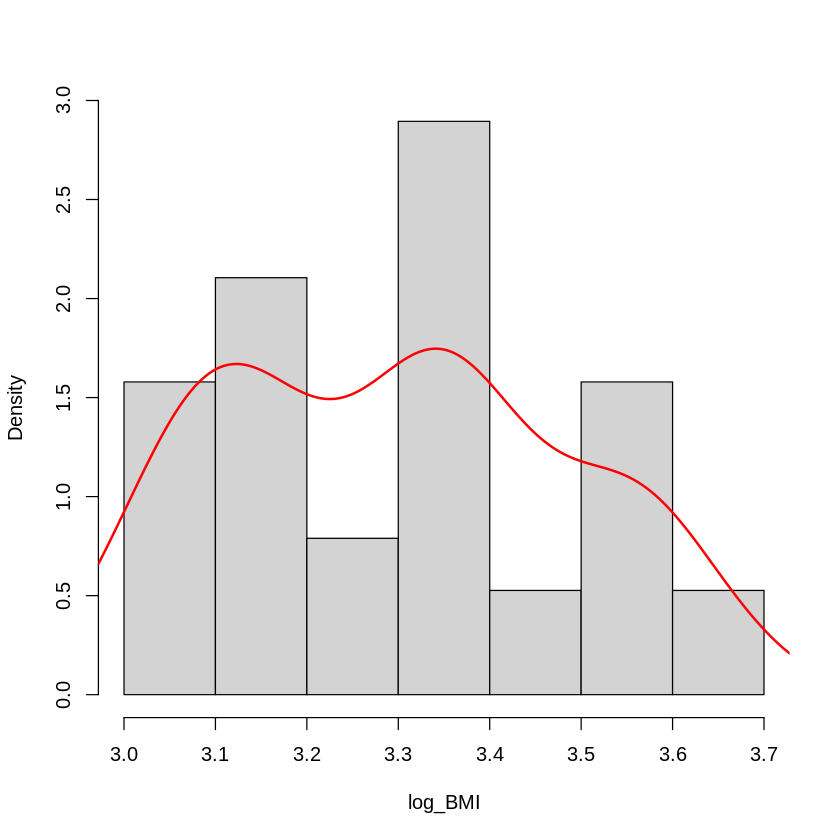

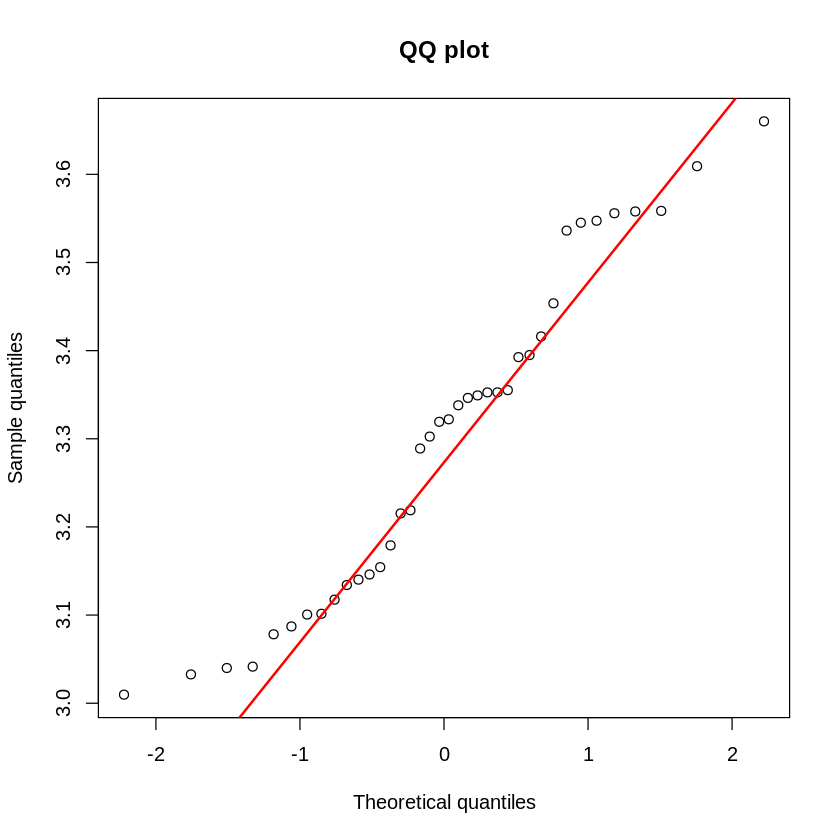

In [16]:
check_normality(log_BMI, "log_BMI")

In [17]:
clinical_data[[paste0("log_", indep_var)]] <- log(clinical_data[[indep_var]])

In [18]:
# Выбираем зависимую и независимую гипотезы
dep_var <- "Dm"
indep_var <- "log_BMI"

In [19]:
# Создайте логистическую регрессионную модель
logistic_model <- glm(as.formula(paste(dep_var, "~", indep_var)), data = clinical_data, family = binomial())

In [20]:
# Получите результаты модели
summary(logistic_model)

# Функция для выбора гипотезы на основе результатов логистической регрессии
choose_hypothesis <- function(logistic_model) {
  p_value <- summary(logistic_model)$coefficients[2, 4]

  if (p_value < 0.05) {
    decision <- "Отвергаем нулевую гипотезу"
  } else {
    decision <- "Не отвергаем нулевую гипотезу"
  }
}

# Вызовите функцию для выбора гипотезы
hypothesis <- choose_hypothesis(logistic_model)
print(hypothesis)


Call:
glm(formula = as.formula(paste(dep_var, "~", indep_var)), family = binomial(), 
    data = clinical_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -18.571     11.269  -1.648   0.0993 .
log_BMI        4.887      3.291   1.485   0.1376  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 25.574  on 37  degrees of freedom
Residual deviance: 22.989  on 36  degrees of freedom
AIC: 26.989

Number of Fisher Scoring iterations: 5


[1] "Не отвергаем нулевую гипотезу"


Остатки по QQ плот распределены ненормально

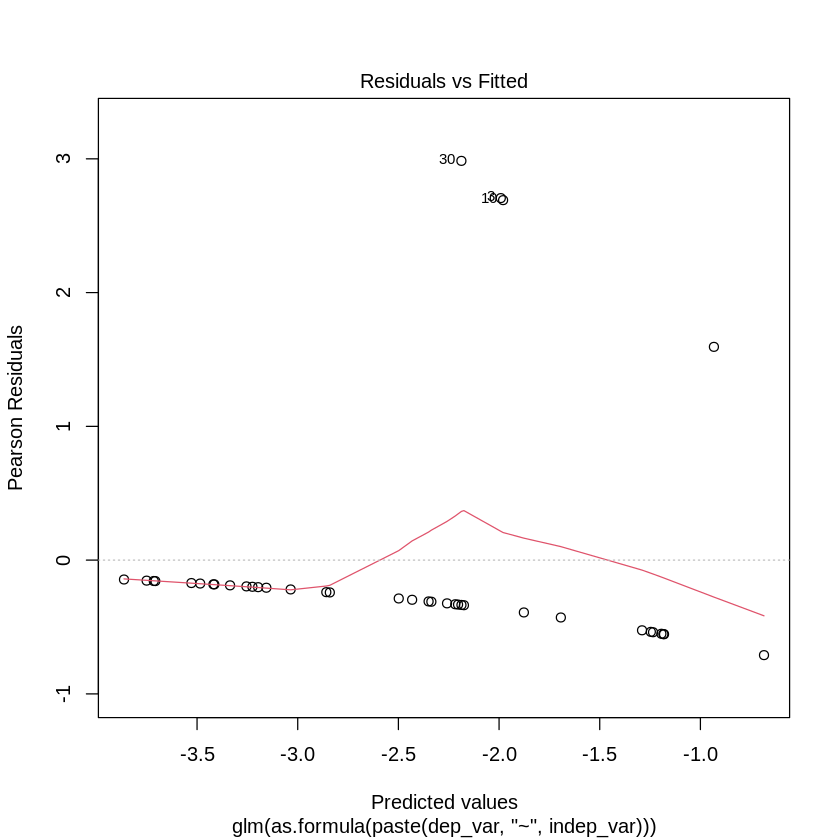

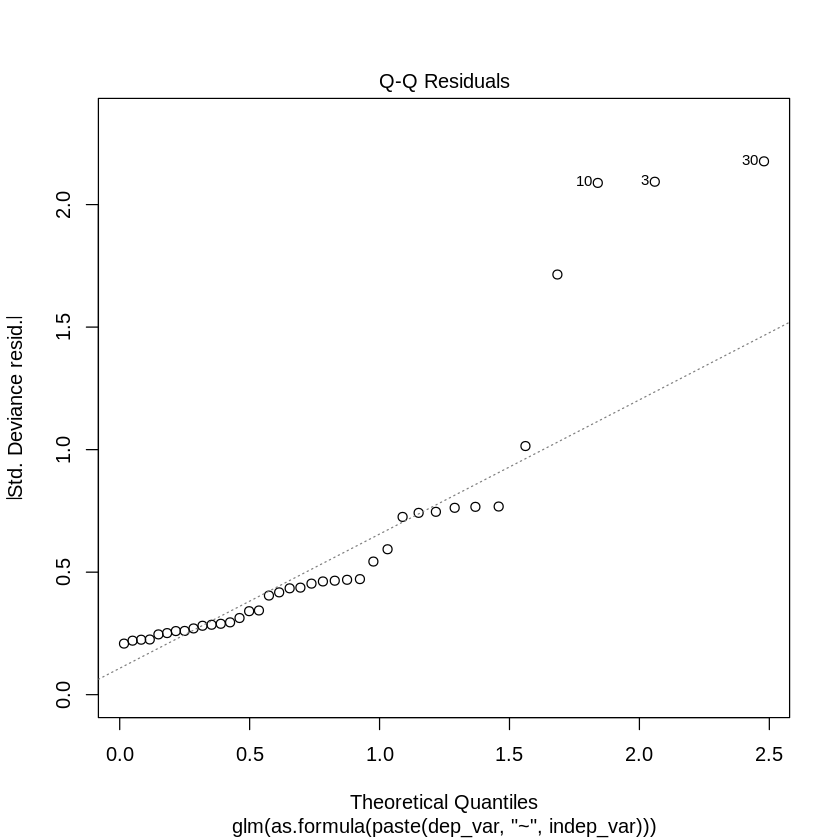

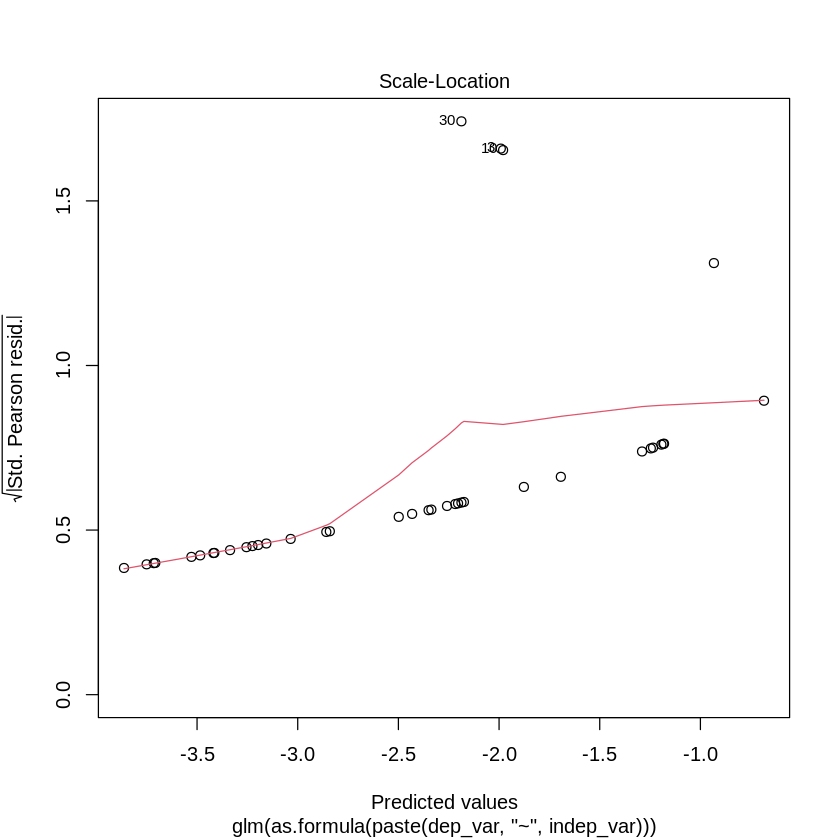

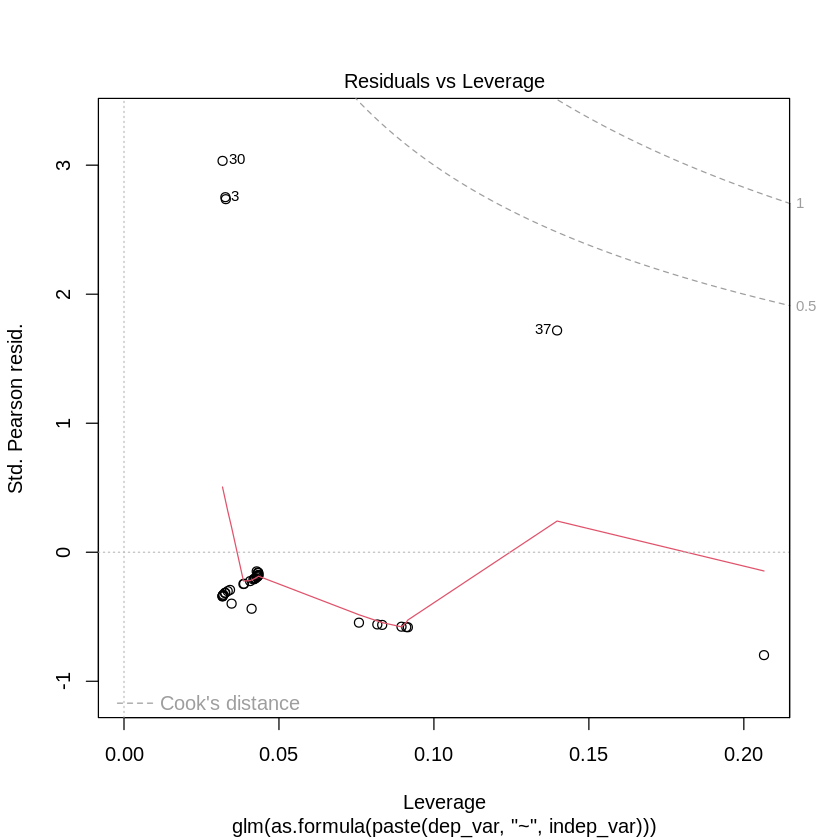

In [21]:
plot(logistic_model)

## Гипотеза 2: множественная логистическая регрессия

**Нулевая гипотеза (H0):**

Вероятность развития диабета (Dm) не зависит от уровня холестерина (Choi.26) и индекса массы тела (BMI) пациентов.

**Альтернативная гипотеза (H1):**

Вероятность развития диабета (Dm) зависит от уровня холестерина (Choi.26) и индекса массы тела (BMI) пациентов.

In [22]:
# Определяем зависимую и независимые переменные
dep_var <- "Dm"
indep_var1 <- "BMI"
indep_var2 <- "Choi.29"

In [23]:
# Преобразуем независимую переменную BMI в логарифмическую шкалу
clinical_data$log_BMI <- log(clinical_data$BMI)

# Создаём логистическую регрессионную модель с двумя независимыми переменными
logistic_model <- glm(as.formula(paste(dep_var, "~", indep_var1, "+", indep_var2)), data = clinical_data, family = binomial())

# Результаты модели
summary(logistic_model)

# Функция для выбора гипотезы на основе результатов логистической регрессии
choose_hypothesis <- function(logistic_model) {
  p_value1 <- summary(logistic_model)$coefficients[2, 4]
  p_value2 <- summary(logistic_model)$coefficients[3, 4]

  if (p_value1 < 0.05 & p_value2 < 0.05) {
    decision <- "Отвергаем нулевую гипотезу"
  } else {
    decision <- "Не отвергаем нулевую гипотезу"
  }
  return(decision)
}

# Вывод гипотезы
hypothesis <- choose_hypothesis(logistic_model)
print(hypothesis)


Call:
glm(formula = as.formula(paste(dep_var, "~", indep_var1, "+", 
    indep_var2)), family = binomial(), data = clinical_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -0.2939     4.5609  -0.064   0.9486  
BMI           0.1778     0.1074   1.656   0.0976 .
Choi.29      -1.1810     0.7004  -1.686   0.0918 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 25.574  on 37  degrees of freedom
Residual deviance: 19.329  on 35  degrees of freedom
AIC: 25.329

Number of Fisher Scoring iterations: 6


[1] "Не отвергаем нулевую гипотезу"


## Гипотеза 3: линейная регрессия

**Нулевая гипотеза (H0):**
Средняя толщина интима-медии сонной артерии (carotid.IMT.mean) не зависит от уровня холестерина LDL и курения.

**Альтернативная гипотеза (H1):**

Хотя бы один из коэффициентов регрессии для уровня холестерина LDL (LDLi.28) и курения (Sm) отличен от нуля. Это означает, что средняя толщина интима-медии сонной артерии (carotid.IMT.mean) зависит от уровня холестерина LDL и/или курения.

Эта гипотеза предполагает, что уровень холестерина LDL и курение влияют на среднюю толщину интима-медии сонной артерии.

Для формирования выборок будем использовать jacknife.

In [24]:
# Определяем функцию для jacknife ресемплинга линейной регрессии
jacknife_lm <- function(dep_var, indep_var1, indep_var2, data) {
  # Определяем размер выборки
  n <- nrow(data)

  # Создаём матрицу для хранения коэффициентов регрессии
  coefs <- matrix(ncol = 3, nrow = n)
  colnames(coefs) <- c("Intercept", indep_var1, indep_var2)

  # Проведем n итераций jacknife ресемплинга
  for (i in 1:n) {
    # Создаём выборку, исключив i-тый элемент
    sample_data <- data[-i, ]

    # линейная модель
    lm_model <- lm(as.formula(paste(dep_var, "~", indep_var1, "+", indep_var2)), data = sample_data)

    # Сохраним коэффициенты регрессии
    coefs[i, ] <- coef(lm_model)
  }

  # Вычислим среднее значение и стандартное отклонение коэффициентов регрессии
  mean_coefs <- apply(coefs, 2, mean)
  sd_coefs <- apply(coefs, 2, sd)

  # Вернем среднее значение и стандартное отклонение коэффициентов регрессии
  return(list(mean_coefs = mean_coefs, sd_coefs = sd_coefs, coefs = coefs))
}

# Определяем функцию для выбора гипотезы на основе результатов линейной регрессии
choose_hypothesis <- function(lm_model) {
  p_value1 <- summary(lm_model)$coefficients[2, 4]
  p_value2 <- summary(lm_model)$coefficients[3, 4]

  if (p_value1 < 0.05 & p_value2 < 0.05) {
    decision <- "Отвергаем нулевую гипотезу"
  } else {
    decision <- "Не отвергаем нулевую гипотезу"
  }
  return(decision)
}

In [25]:
# Определяем зависимую и независимые переменные
dep_var <- "carotid.IMT.mean"
indep_var1 <- "LDLi.28"
indep_var2 <- "Sm"

In [26]:
# Проведем jacknife ресемплинг и получим вектор коэффициентов регрессии
jacknife_result <- jacknife_lm(dep_var, indep_var1, indep_var2, clinical_data)

In [27]:
# Построим линейную регрессионную модель на всей выборке
lm_model <- lm(as.formula(paste(dep_var, "~", indep_var1, "+", indep_var2)), data = clinical_data)

In [28]:
# Выберем гипотезу на основе результатов линейной регрессии
hypothesis <- choose_hypothesis(lm_model)
print(hypothesis)

[1] "Не отвергаем нулевую гипотезу"


In [29]:
# Выведем среднее значение и стандартное отклонение коэффициентов регрессии
cat("Среднее значение коэффициентов регрессии:", jacknife_result$mean_coefs, "\n")
cat("Стандартное отклонение коэффициентов регрессии:", jacknife_result$sd_coefs, "\n")

Среднее значение коэффициентов регрессии: 0.8167927 -8.249073e-05 0.04108285 
Стандартное отклонение коэффициентов регрессии: 0.0170898 9.841249e-05 0.008916218 


In [30]:
summary(lm_model)


Call:
lm(formula = as.formula(paste(dep_var, "~", indep_var1, "+", 
    indep_var2)), data = clinical_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.22476 -0.08642  0.02039  0.04905  0.28950 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.169e-01  8.399e-02   9.727 1.74e-11 ***
LDLi.28     -8.308e-05  5.269e-04  -0.158    0.876    
Sm1          4.102e-02  7.745e-02   0.530    0.600    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1273 on 35 degrees of freedom
Multiple R-squared:  0.009566,	Adjusted R-squared:  -0.04703 
F-statistic: 0.169 on 2 and 35 DF,  p-value: 0.8452


In [37]:
# # Выведем матрицу коэффициентов регрессии
# cat("\nМатрица коэффициентов регрессии:\n")
# print(jacknife_result$coefs)

In [35]:
# # Создадим данные для графика
# coef_dist <- data.frame(coef = as.vector(coefs))

In [32]:
# # Построим гистограмму
# ggplot(coef_dist, aes(x = coef)) +
#   geom_histogram(binwidth = 0.01, fill = "blue", color = "black") +
#   labs(x = "Коэффициент регрессии", y = "Частота") +
#   theme_bw()

ERROR: Error in eval(expr, envir, enclos): object 'coef_dist' not found


In [ ]:
# # Построим ядерную плотность
# ggplot(coef_dist, aes(x = coef)) +
#   geom_density(fill = "blue", color = "black") +
#   labs(x = "Коэффициент регрессии", y = "Плотность") +
#   theme_bw()